# Forecasting consumable sales of Markem Image : a company that make industrial printer

Matthieu Roux

The aim is to implement statistical forecasting model to predict the consumable sales of Markem Image, using statistical model and machine learning models

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings

import statsmodels.api as sm

import itertools
import statsmodels.api as sm

#from croston import croston
import statsmodels as sml

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.exponential_smoothing.ets

import xgboost as xgb
import shap

import datetime
from datetime import datetime as dt

from dateutil import relativedelta

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import os
os.chdir("c:\\Users\\matth\\Documents\\09 - idées en vrac\\02 - Proj cod\\serie_temp\\consumable")

## Data processing

In [4]:
def process_data(pref, file, vizualize = False):
    #import the file converting string date to datetime format
    consumable = pd.read_csv(pref+file, sep = ',', parse_dates = [3])
    # Grouping by month summing quantity per month
    grouped_consumable = consumable.groupby('Posting date').sum('Quantity')
    grouped_consumable = grouped_consumable.groupby(pd.Grouper(freq="ME")).sum()
    if vizualize :
        plt.plot(grouped_consumable.index, grouped_consumable['Quantity'])
        plt.title("Vizualisation of "+file.split('.')[0])
    return consumable, grouped_consumable

pref = "Data/"
cons1, grouped_cons1= process_data(pref, 'consumable_part1.csv')
cons2, grouped_cons2 = process_data(pref, 'consumable_part2.csv')
cons3, grouped_cons3 = process_data(pref, 'consumable_part3.csv')
cons4, grouped_cons4 = process_data(pref, 'consumable_part4.csv')
cons5, grouped_cons5 = process_data(pref,'consumable_part5.csv')
cons6, grouped_cons6 = process_data(pref,'consumable_part6.csv')

df_grouped = pd.concat([cons1, cons2, cons3, cons4, cons5, cons6])
df_client = df_grouped.copy()
df_client.to_csv(pref+'consumable_sales.csv')
serie_qte= df_grouped.groupby('Posting date').sum('Quantity')
serie_qte = serie_qte.groupby(pd.Grouper(freq="ME")).sum()['Quantity']
serie_qte = serie_qte.reset_index()
serie_qte.Quantity = serie_qte.Quantity.astype('float64')
serie_qte.columns = serie_qte.columns.str.replace('Posting date', 'Date')
serie_qte.to_csv(pref+'qte_vendu_mois.csv')

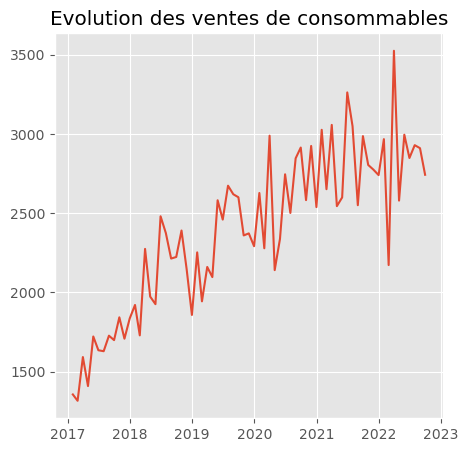

In [4]:
fig,ax = plt.subplots(figsize = (5,5))
ax.plot(serie_qte.set_index('Date'))
ax.set_title("Evolution des ventes de consommables")
plt.savefig('fig/evolution_ventes_consommables.png')

## Satistical predictions

We first make predictions using statistical models such as Holtwinters or Arima. The file qte_vendu_mois.csv contains consumable sold per month.


This serie seems to have an ascending trend from 2017 to 2021. Then it drops on the december 2020 and january 2021. Then, the trend seems to be constant.

### Decemposition of the serie

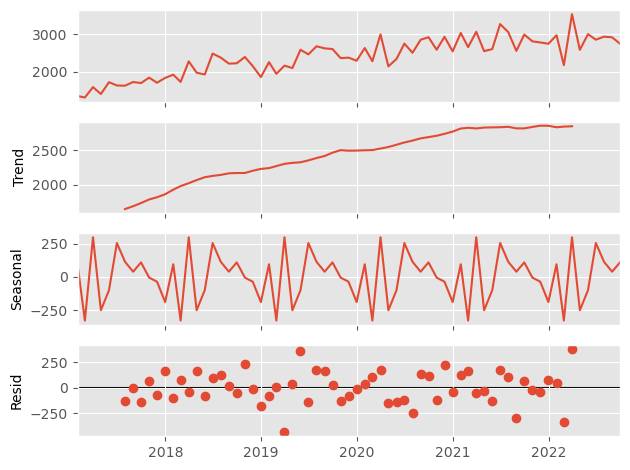

In [4]:
decompose_result_add = seasonal_decompose(serie_qte.set_index('Date'),model='additive', period =12)
decompose_result_add.plot(); plt.savefig('fig/Decomposition_additive.png')

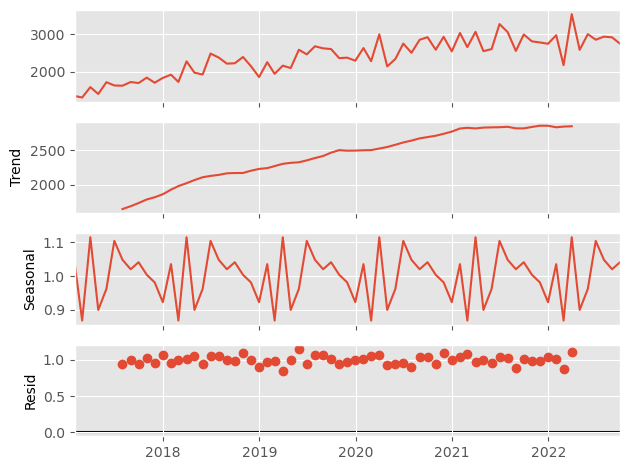

In [5]:
decompose_result_mult = seasonal_decompose(serie_qte.set_index('Date'),model='multiplicative', period=12)
decompose_result_mult.plot(); plt.savefig('fig/Decomposition_mul.png')

Multiplicative model seems to have smallest residuals and a saisonnality which have a smallest amplitude. It seems better to use a multiplicative model on our data



### Using the whole database
We fit Holtwinters model firstly on the whole database. Holt-Winters model is an exponential model that take into account seasonality and pics.
The base of this method are the 3 equations : 

$$ \hat{a}_{T,1}=\alpha(X_T-\hat{S}_{T-d} )+(1-\alpha)(\hat{a}_{T-1,1}+\hat{a}_{T-1,2}) \\
  \hat{a}_{T,2}=(1-β) \hat{a}_{T-1,2} + β(\hat{a}_{T,1}+\hat{a}_{T-1,1}) \\
 \hat{S}_T=γ(X_t-\hat{a}_{T,1} )+(1-γ)\hat{S}_{T-d}
$$


In [6]:
def time_serie_model(data, func, trend = 'mul', seasonal ='add', seasonal_period = 12, viz=True, date_sep = '2021-01-01'):
  """
  time_serie_model
  Fit a time serie model, compute mean absolute error and mean square error
  """
  train = data.loc[data['Date']<=date_sep,:]
  test = data.loc[data['Date']>date_sep,:]
  fitted_model = func(train.Quantity, trend=trend,seasonal=seasonal,seasonal_periods=seasonal_period).fit()
  fitted_values = fitted_model.fittedvalues
  mae_train = mean_absolute_error(train.Quantity,fitted_values)
  print(f'Mean Absolute Error on train = {mae_train}')


  # The following command gave good result until the 18/01/2023. Now an error arrives. cf https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html
  #pred = fitted_model.get_prediction(start=start, end=end, simulate_repetitions = 500)
  #print(type(pred))
  #df_pred = pred.summary_frame(alpha=0.05)

  # We code something similare to get prediction, which return CI and mean prediction
  df_simul = fitted_model.simulate(
    nsimulations=test.shape[0],
    repetitions=1000,
    anchor='end')
  df_pred = pd.DataFrame({'Date' : df_simul.index, 'mean' : df_simul.mean(axis = "columns"),
                          'pi_upper' : df_simul.quantile(0.975, axis = "columns"), 'pi_lower' : df_simul.quantile(0.025, axis = "columns")  })
  df_pred.set_index('Date')
  mae_test = mean_absolute_error(test.Quantity,df_pred['mean'])
  print(f'Mean Absolute Error on test = {mae_test}')
  #Vizualisation
  if viz:
    fig,ax = plt.subplots(figsize = (11,7))

    ax.plot(data.Date, data.Quantity, label = "real values")
    ax.plot(train.Date, fitted_values, label = "fitted_values")
    ax.plot(test.Date,df_pred['mean'], label = "predicted_values")
    ax.plot(test.Date,df_pred['pi_lower'], label = "CI 0.95", color = 'blue', linestyle = "--")
    ax.plot(test.Date,df_pred['pi_upper'], label = "CI 0.95", color = 'blue', linestyle = "--")
    ax.set_title("Prédiction des ventes de consommables \n avec un modèle de Holtwinters "+trend)
    plt.legend()
    plt.savefig("fig/pred_Holtwinters_"+trend+".png")
  return fitted_model, df_pred, mae_train, mae_test

Mean Absolute Error on train = 132.06969232914898
Mean Absolute Error on test = 319.8493382338266


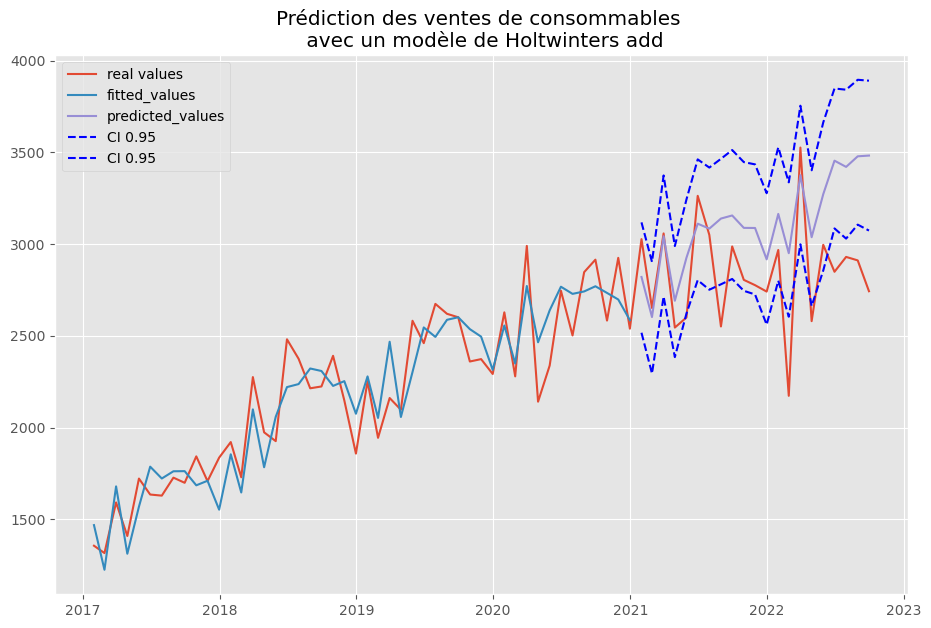

In [7]:
fitted_holt1, df_pred_holt1, mae_train_holt1, mae_test_holt1  =  time_serie_model(serie_qte, ETSModel, trend = 'add', seasonal ='add', seasonal_period = 12, viz=True, date_sep = '2021-01-01')

Mean Absolute Error on train = 125.43525640720894
Mean Absolute Error on test = 406.1621739438259


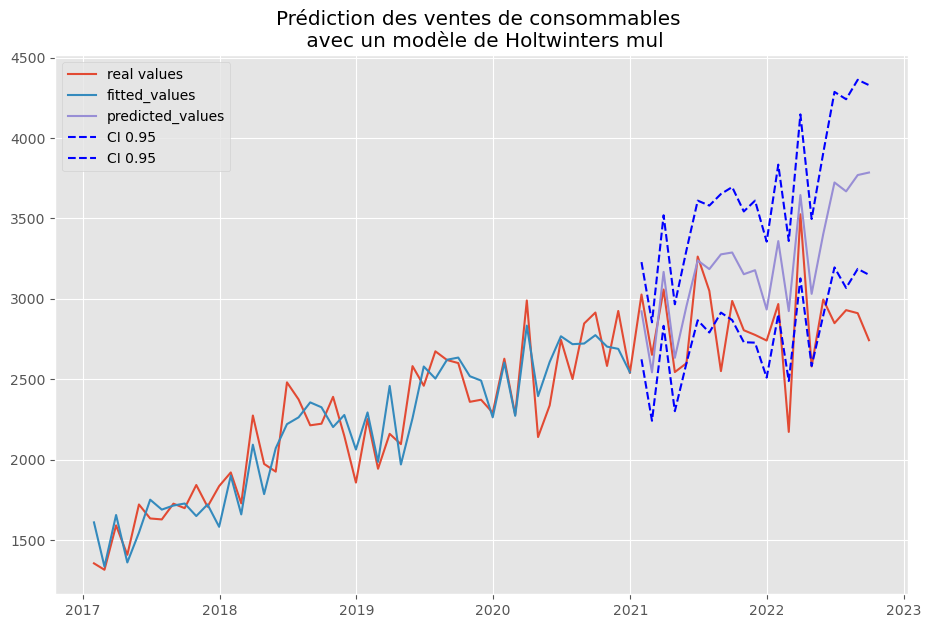

In [8]:
fitted_holt2,df_pred_holt2, mae_train_holt2, mae_test_holt2 = time_serie_model(serie_qte, ETSModel, trend = 'mul', seasonal ='mul', seasonal_period = 12, viz=True, date_sep = '2021-01-01')

Both Hot-Winters models predict well trend and high pics. However, low pics are not well predicted.

### ARIMA Model

In [9]:
from pmdarima.arima import auto_arima
from pmdarima.utils import acf, pacf
import pmdarima.utils as pmdu

In [10]:
date_sep = '2021-01-01'
train = serie_qte.loc[serie_qte['Date']<=date_sep,['Date', 'Quantity']].set_index('Date')
test = serie_qte.loc[serie_qte['Date']>date_sep,['Date', 'Quantity']].set_index('Date')

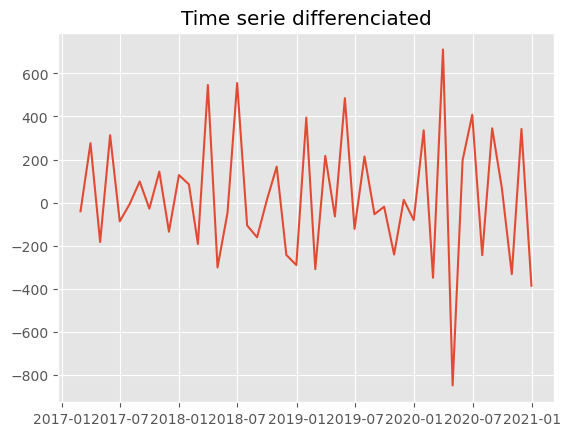

In [11]:
plt.plot(train.diff()[1:])
plt.title("Time serie differenciated")
plt.savefig("fig/time_serie_diff.png")

The time serie differenciated seems to be stationary so the arma model need to be fitted on the differenciated serie

c:\Users\matth\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


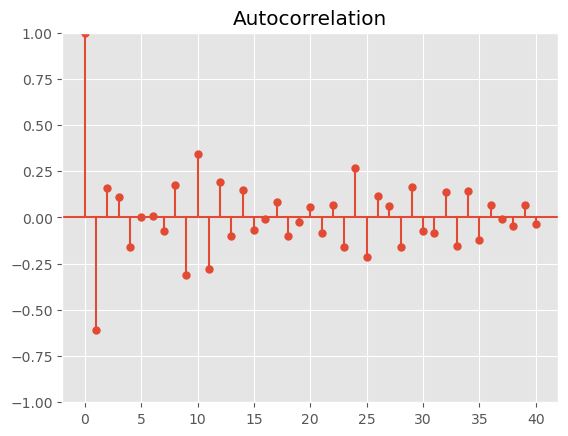

In [12]:
pmdu.plot_acf(train.diff()[1:], lags = 40)

The autocorrelation become close to zero after a lag of 1 so we have an MA(1) process on the differenciated serie which leads us to an ARIMA(0,1,1) on the original time serie. Let see what gives us the auto_arima formulation, that minimize AIC.

In [13]:
arima_model = auto_arima(train,start_p= 0,d= 1,start_q=0,max_p = 5,max_d=5,max_q=5,start_P= 0,start_Q=0,max_P=5,max_Q=5,m=8,seasonal = True,stepwise = True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=672.029, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[8] intercept   : AIC=653.579, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=649.388, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[8]             : AIC=670.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[8] intercept   : AIC=647.410, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[8] intercept   : AIC=649.679, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[8] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[8] intercept   : AIC=649.004, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[8] intercept   : AIC=649.319, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[8] intercept   : AIC=651.619, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[8] intercept   : AIC=650.831, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[8]             : AIC=652.649, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[8] intercept
Total fit time: 1.651 seconds


We get an ARIMA(0,1,1) with no seasonal components.

In [14]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -320.705
Date:                Thu, 06 Mar 2025   AIC                            647.410
Time:                        12:15:58   BIC                            652.960
Sample:                    01-31-2017   HQIC                           649.498
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     28.0454      4.610      6.084      0.000      19.010      37.081
ma.L1         -0.8675      0.091     -9.518      0.000      -1.046      -0.689
sigma2      4.768e+04   1.08e+04      4.415      0.000    2.65e+04    6.88e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.71   Prob(JB):                         0.79
Heteroskedasticity (H):               3.05   Skew:                            -0.20
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
fitted_arima = arima_model.predict_in_sample(start=1, end=len(train))
prediction_arima,confidance_interval = arima_model.predict(n_periods=test.shape[0],return_conf_int=True,alpha=0.05)
prediction_arima = pd.DataFrame(prediction_arima)
confidance_interval = pd.DataFrame(confidance_interval)
confidance_interval.index = prediction_arima.index

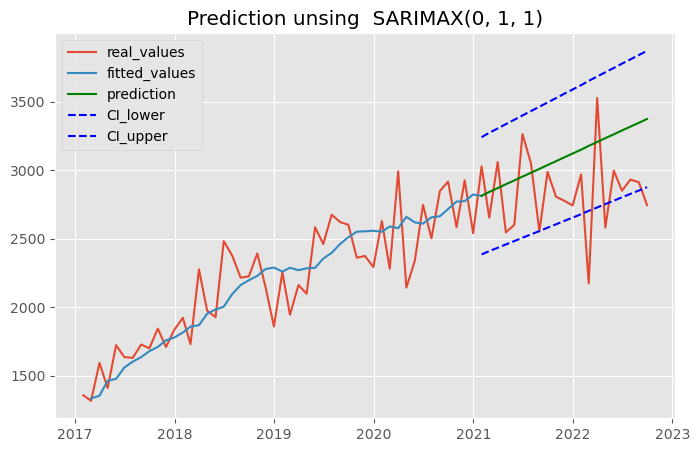

In [16]:
plt.figure(figsize=(8,5))
plt.plot(serie_qte.Date, serie_qte.Quantity,label ='real_values')
plt.plot(fitted_arima, label = 'fitted_values')
plt.plot(prediction_arima,label = 'prediction', color ='green' )
plt.plot(confidance_interval.index, confidance_interval[0],color = 'blue', linestyle = "--", label = 'CI_lower')
plt.plot(confidance_interval.index, confidance_interval[1],label = 'CI_upper', color = 'blue', linestyle = "--")
plt.legend()
plt.title("Prediction unsing  SARIMAX(0, 1, 1)")
plt.savefig('fig/sarimax(0,1,1).png')

ARIMA model is predicting the trend in a good manner but the pics are not well predicted.

In [17]:
mae_arima_train = mean_absolute_error(train.Quantity,fitted_arima)
mae_arima_test = mean_absolute_error(test.Quantity, prediction_arima)
print(f'Mean Absolute Error on train = {mae_arima_train}')
print(f'Mean Absolute Error on test = {mae_arima_test}')

Mean Absolute Error on train = 147.20915837290605
Mean Absolute Error on test = 353.4616769085634


### Comparison of statistical models models

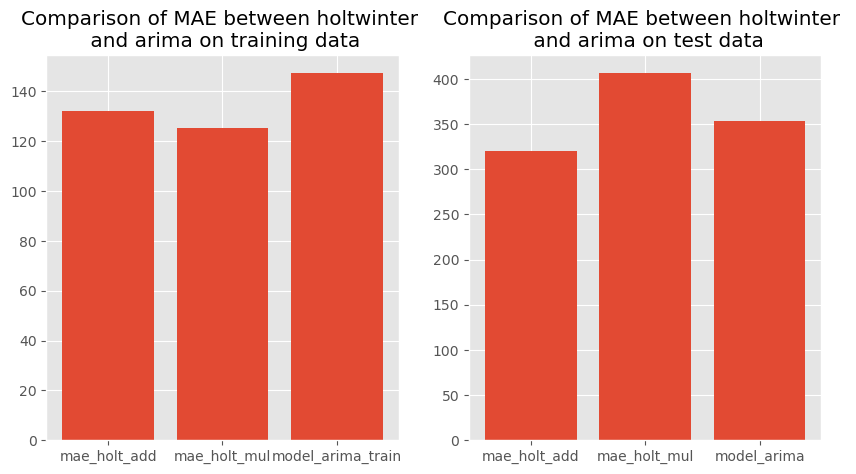

In [18]:
fig,ax = plt.subplots(figsize = (10,5), ncols = 2)
ax[0].bar(['mae_holt_add', 'mae_holt_mul', 'model_arima_train'], height = [mae_train_holt1, mae_train_holt2,mae_arima_train])
ax[0].set_title("Comparison of MAE between holtwinter \n and arima on training data")
ax[1].bar(['mae_holt_add', 'mae_holt_mul', 'model_arima'], height = [mae_test_holt1, mae_test_holt2,mae_arima_test])
ax[1].set_title("Comparison of MAE between holtwinter \n and arima on test data")
plt.savefig(pref+'compare_statistical_models.png')

## Prediction using Machine Learning
### Data preparation : we want to integrate mean age of printer and there mean age

In [5]:
df_client = pd.concat([cons1, cons2, cons3, cons4, cons5, cons6])
df_client= df_client.groupby(['Posting date', "Ship-To Party"], as_index = False).sum()
len(df_client['Ship-To Party'].unique())
df_printer_sales = pd.read_csv(pref + "Printer_sales.csv", sep=',', parse_dates = [1])
print(f"Number of client in consumable df : {len(df_client['Ship-To Party'].unique())}")
print(f"Number of client in printer_sales df : {len(df_printer_sales['Ship-to'].unique())}")
print(f"Number of sector in printer_sales df : {len(df_printer_sales['Sector_code'].unique())}")
print(f"Number of country in printer_sales df : {len(df_printer_sales['Country_Code'].unique())}")
print(f"Number of country zone in printer_sales df : {len(df_printer_sales['Country_Zon'].unique())}")

# On enlève les strings des code (de secteur, et de pays)
df_printer_sales['Sector_code'] = df_printer_sales['Sector_code'].apply(lambda x : int(x.split('_')[1]))
df_printer_sales['Country_Code'] = df_printer_sales['Country_Code'].apply(lambda x : int(x.split('_')[1]))
df_printer_sales['Country_Zon'] = df_printer_sales['Country_Zon'].apply(lambda x : int(x.split('_')[1]))

Number of client in consumable df : 8663
Number of client in printer_sales df : 8663
Number of sector in printer_sales df : 17
Number of country in printer_sales df : 26
Number of country zone in printer_sales df : 9


Text(0.5, 1.0, 'Monthly printer sales')

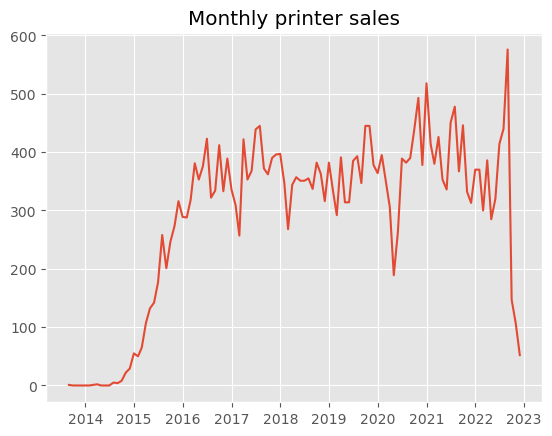

In [6]:
serie_grouped_printer_sales = df_printer_sales.groupby('Equip. Starting date')['Count of Serial number'].sum()
serie_grouped_printer_sales = serie_grouped_printer_sales.groupby(pd.Grouper(freq="ME")).sum()
fig,ax =plt.subplots()
plt.plot(serie_grouped_printer_sales)
plt.title("Monthly printer sales")

Text(0.5, 1.0, 'Cumulated printer sales')

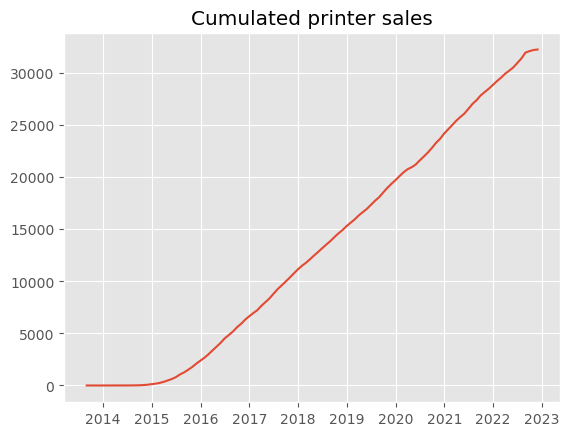

In [7]:
plt.plot(serie_grouped_printer_sales.cumsum())
plt.title("Cumulated printer sales")

In [11]:
grouped_printer_sales_nb = df_printer_sales.groupby('Equip. Starting date').sum('Count of Serial number')
grouped_printer_sales_nb = grouped_printer_sales_nb.groupby(pd.Grouper(freq="ME")).sum()
grouped_printer_sales_nb["nb_printer_at_date"] = grouped_printer_sales_nb['Count of Serial number'].cumsum()
grouped_printer_sales_nb = grouped_printer_sales_nb[['Count of Serial number', "nb_printer_at_date"]]
grouped_printer_sales_nb = grouped_printer_sales_nb.reset_index()
grouped_printer_sales_nb = grouped_printer_sales_nb[grouped_printer_sales_nb['Equip. Starting date'] >= "2014-02-28"]

In [12]:
dateMin = np.min(df_printer_sales['Equip. Starting date'])
med_age = np.zeros(grouped_printer_sales_nb.shape[0])
mean_age = np.zeros(grouped_printer_sales_nb.shape[0])
for i in range(6,grouped_printer_sales_nb.shape[0] ):
  d_day = grouped_printer_sales_nb['Equip. Starting date'][i]
  vec_tmp_med = []
  vec_tmp_mean = []
  for date in grouped_printer_sales_nb.loc[grouped_printer_sales_nb['Equip. Starting date'] <= d_day, 'Equip. Starting date']:
    vec_tmp_med.append(grouped_printer_sales_nb["Count of Serial number"][i] * [relativedelta.relativedelta(d_day, date).months])
    vec_tmp_mean.append(grouped_printer_sales_nb["Count of Serial number"][i] * relativedelta.relativedelta(d_day, date).months)
  med_age[i] = np.median(np.array(vec_tmp_med))
  mean_age[i] = np.array(vec_tmp_mean).sum()/grouped_printer_sales_nb.loc[grouped_printer_sales_nb['Equip. Starting date'] <= d_day, 'Count of Serial number'].sum()
  grouped_printer_sales_nb["mean_age"] = mean_age

Mean of empty slice.
invalid value encountered in double_scalars


In [14]:
df_consumable = serie_qte.reset_index()
df_consumable.columns = df_consumable.columns.str.replace('Posting date', 'Date')
df_consumable.Date = df_consumable.Date.astype('datetime64[ns]')
grouped_printer_sales_nb.columns = grouped_printer_sales_nb.columns.str.replace('Equip. Starting date', 'Date')
df_cumulative = pd.merge(df_consumable, grouped_printer_sales_nb, on = "Date" )
df_cumulative["Year"] = df_cumulative['Date'].dt.year
df_cumulative['Month'] = df_cumulative['Date'].dt.month
df_cumulative = df_cumulative.drop([ 'Count of Serial number'], axis = 1)
df_cumulative.to_csv('Data\\consumable_cumulative_printer_sales.csv')

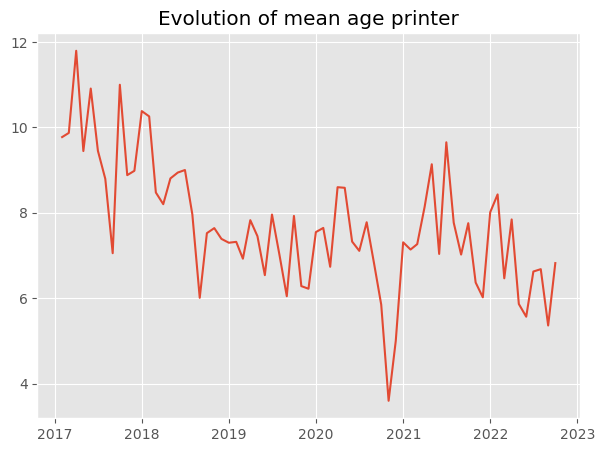

In [16]:
fig,ax = plt.subplots(figsize = (7,5))
ax.plot(df_cumulative.Date, df_cumulative.mean_age)
ax.set_title("Evolution of mean age printer")
plt.savefig('fig\\evolution_mean_age.png')

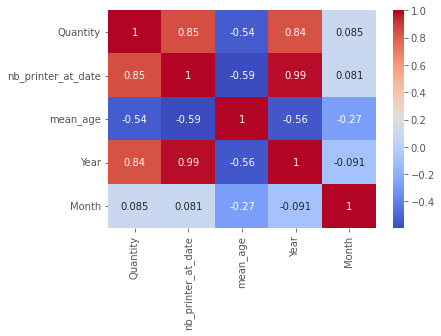

In [ ]:
# Corelation
sns.heatmap(df_cumulative.drop("Date", axis = 1).corr(), annot=True, cmap='coolwarm')

The corelation shows us that year and nb_printer at date are strongly corelated which sounds obvious. These 2 variables are positively corelated to Quantity. 
Mean age is negatively corelated to quantity.
Month is not corelated to quantity, this show that this time serie does not have a strong seasonal component.

### XGBOOST
In this part we use XGBOOST model to predict consumables sales. 
XGBOOST models are known to be relevant for time series

#### Modelisation

Separating training and test dataset

In [ ]:
def split(df, date_sep):
  """
  split
  Split a dataframe between train and test dataset using a date
  Params
  -------
  df : pandas.dataframe, the dataframe we want to split

  Return
  -------
  train and test dataframes
  """
  train= df.loc[df['Date']<=date_sep,:]
  train.drop("Date", axis = 1, inplace = True)
  test = df.loc[df['Date']>date_sep,:]
  test.drop("Date", axis = 1, inplace = True)
  return train,test

def get_XY(df,name):
  """
  get_XY
  Get the df with explanatory variable and the df with the variable we want to predict
  Params
  ------
  df : pandas.DataFrame, the initial dataframe
  name : str, the column of the df coresponding to the variable we want to predict

  Returns
  -------
  X and Y
  """
  Y=df[name]
  X=df[df.columns]
  X=X.drop(name,axis=1)
  X=X.reset_index(drop=True)
  Y=Y.reset_index(drop=True)
  return X,Y

#### Model and predictions

We use an XGboost model because it does not need standardize data and it is used to fit time series.

In [ ]:
def find_best_params(X_train, Y_train):
  """
  find_best_params
  Find the best parameters of the XGBoost model using a gridsearch method
  Params
  ------
  X_train, Y_train

  Returns
  -------

  """
  grid_model = xgb.XGBRegressor()
  parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                'objective':['reg:squarederror'],
                'learning_rate': [.03, 0.05, .07], #so called `eta` value
                'max_depth': [3,5],
                'min_child_weight': [1,2],
                'silent': [1],
                'subsample': [0.5,0.7],
                'colsample_bytree': [0.5,0.7]}

  xgb_grid = GridSearchCV(grid_model,
                          parameters,
                          cv = 2,
                          n_jobs = 5,
                          verbose=True)

  xgb_grid.fit(X_train,Y_train)
  return xgb_grid.best_params_

def pipe(df, date_sep):
  """
  Pipeline Function which fits the model, makes the prediction and computes mean absolute error
  Params
  ------
  df : pandas.DataFrame : the dataframe
  date_sep : the date to separate train and test data

  Return
  -------
  predictions_train : predictions on train data
  predictions : predictoon on test data
  mae_train, mae_test  : KPI to evaluate the model
  data : dictionnary containing data used to fit the model (model, X_train, X_test, Y_test)
  """
  train, test = split(df,date_sep)
  X_train, Y_train = get_XY(train,"Quantity")
  X_test, Y_test = get_XY(test,"Quantity")
  params = find_best_params(X_train, Y_train)

  model = xgb.XGBRegressor(**params)
  model.fit(X_train, Y_train)
  predictions_train = model.predict(X_train)
  predictions = model.predict(X_test)
  mae_train = mean_absolute_error(predictions_train,Y_train)
  mae_test = mean_absolute_error(predictions,Y_test)
  print("mae on training data : " + str(mae_train))
  print("mae on test data : " + str(mae_test))

  data = {"model":model, "X_train": X_train, "X_test" : X_test, 'Y_test': Y_test}

  return predictions_train, predictions, mae_train, mae_test, data

def viz(df_initial, sep_date, predictions_train, predictions, title= "Predictions using XGboost model", name ="viz.png"):
  """
  Function to visualize our model
  """
  fig,ax = plt.subplots(figsize = (5,5))
  ax.plot(df_initial.Date, df_initial.Quantity, label = "real values")
  ax.plot(df_initial.Date[df_initial.Date <= sep_date], predictions_train, label = "fitted_values")
  ax.plot(df_initial.Date[df_initial.Date > sep_date], predictions, label = "predictions")
  ax.set(xlabel = 'time', ylabel = 'Quantity', title = title)
  plt.savefig(pref + "fig\\" +name)
  plt.legend()

#### Prediction on Dataframe with mean age and cumulative sales

In [ ]:
date_sep = dt.fromisoformat('2020-08-31')
predictions_xg_train1, predictions_xg1, mae_xg_train1, mae_xg_test1, data1 = pipe(df_cumulative, date_sep)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[11:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

[11:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.



mae on training data : 83.80680153586648
mae on test data : 305.235009765625


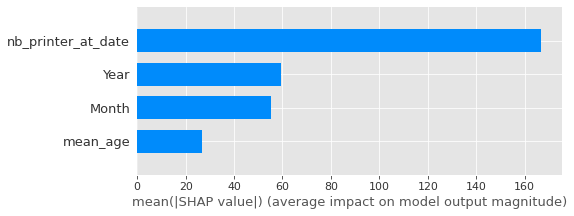

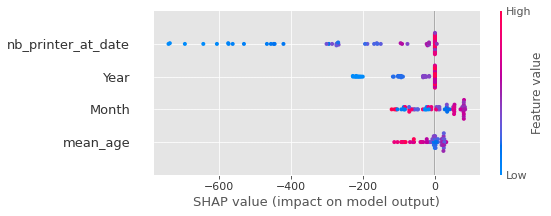

In [ ]:
X1 = pd.concat([data1["X_train"], data1["X_test"]], axis = 0)
explainer = shap.Explainer(data1["model"], data1["X_test"])
# Calculates the SHAP values - It takes some time
shap_values = explainer(X1)
shap.summary_plot(shap_values, plot_type='bar')
shap.summary_plot(shap_values)


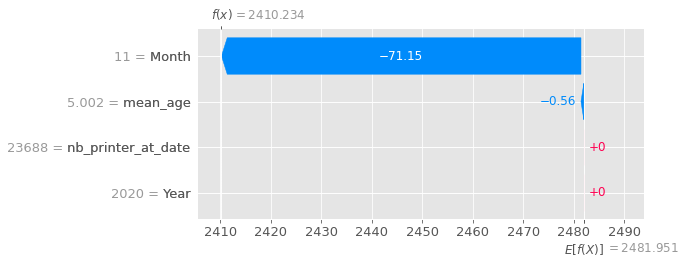

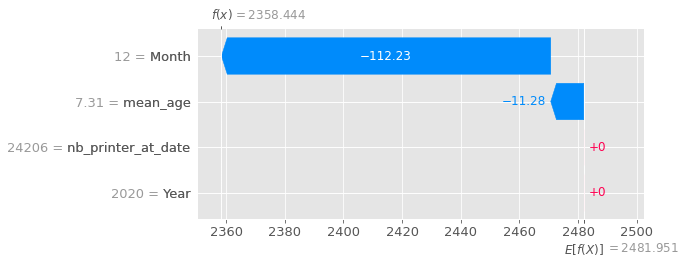

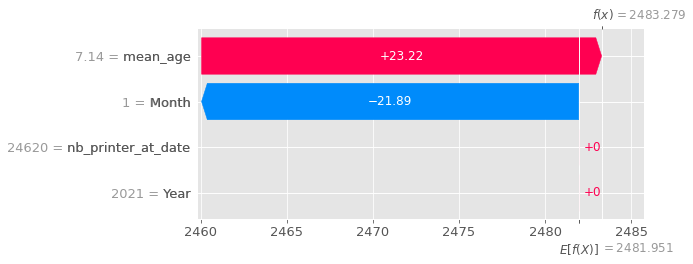

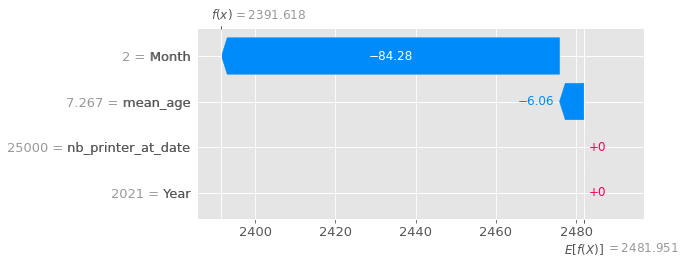

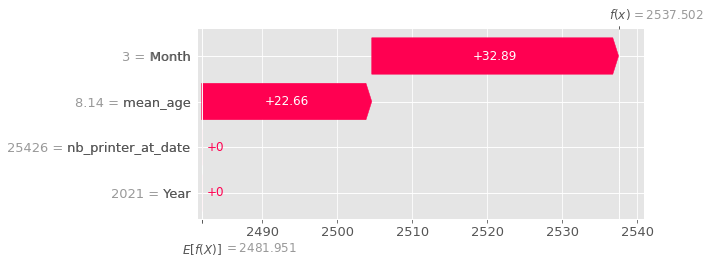

In [ ]:
shap.plots.waterfall(shap_values[46])
shap.plots.waterfall(shap_values[47])
shap.plots.waterfall(shap_values[48])
shap.plots.waterfall(shap_values[49])
shap.plots.waterfall(shap_values[50])

Using our first dataframe, with cumulative sales and and mean age, we see that the rise of mean_age at the beginning of 2021 seems to be responsible for the fall af sales

## Conculsion and comparison between our models

Text(0.5, 1.0, 'Comparison between MAE of xgboost and holtwinter on training data')

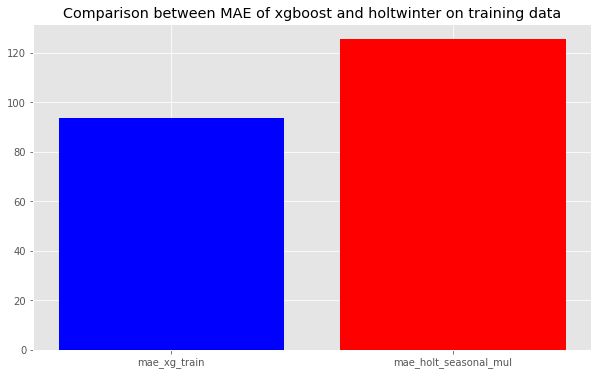

In [ ]:
plt.figure(figsize = (10,6))
plt.bar(['mae_xg_train', 'mae_holt_seasonal_mul'],
        height = [mae_xg_train1, mae_train_holt2],
        color = ['blue','red'])
plt.title("Comparison between MAE of xgboost and holtwinter on training data")

Text(0.5, 1.0, 'Comparison betwwen MAE of xgboost and holtwinter on test data')

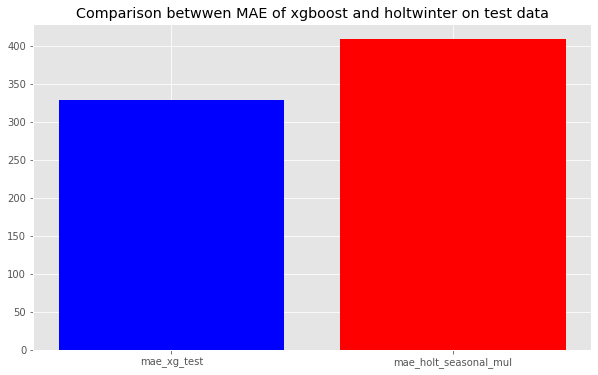

In [ ]:
plt.figure(figsize = (10,6))
plt.bar(['mae_xg_test', 'mae_holt_seasonal_mul_test'],
        height = [mae_xg_test1, mae_test_holt2],
        color = ['blue','red'])
plt.title("Comparison betwwen MAE of xgboost and holtwinter on test data")

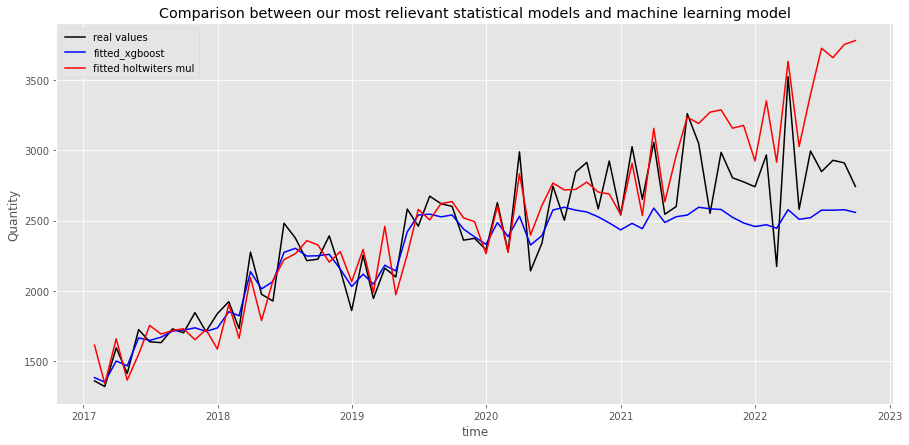

In [ ]:
sep_date = "2021-01-01"
fig,ax = plt.subplots(figsize = (15,7))
ax.plot(serie_qte.Date, serie_qte.Quantity, label = "real values", color = 'black')
ax.plot(serie_qte.Date, list(predictions_xg_train1) + list(predictions_xg1), label = "fitted_xgboost", color = 'blue')
ax.plot(serie_qte.Date, list(fitted_holt2.fittedvalues)+list(df_pred_holt2['mean']), label = 'fitted holtwiters mul', color = 'red')
ax.set(xlabel = 'time', ylabel = 'Quantity', title = "Comparison between our most relievant statistical models and machine learning model")
plt.savefig("/content/drive/MyDrive/Code_INSA_MarkemImage/consumable/fig/"+"comparison")
plt.legend()

Xg boost is our best model according to the MAE on train and test data. However, the holtwinters models seems to predict better high peaks.